In [1]:
import os
import warnings

import matplotlib.pyplot as plt
import librosa
import numpy as np
import pandas as pd
from pandarallel import pandarallel

In [2]:
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [5]:
raw_folder = './raw/'
dataset_folder = './dataset/'
max_freq = 280
min_freq = 40
noise_freq = 60


if not os.path.exists(dataset_folder):
    os.mkdir(dataset_folder)
samples = [d for d in os.listdir(raw_folder) if os.path.isdir(os.path.join(raw_folder, d))]
n_samples = len(samples)
print(samples)

['cv-valid-dev', 'cv-valid-test', 'cv-valid-train']


In [6]:
columns = ["meanfreq", "sd", "median", "q25", "q75", "iqr", "skew", "kurt", "mode", "rms", "chroma", "centroid", "band", "rolloff", "zcr", "label"]

In [7]:
def properties(y: np.ndarray, fs: int):
    spec = np.abs(np.fft.rfft(y))
    freq = np.fft.rfftfreq(len(y), d=1 / fs)

    points_per_freq = len(freq) / (fs / 2)
    # remove the frequencies below and above the human voice range
    spec[int(points_per_freq * max_freq) + 1 : ] = 0
    spec[0 : int(points_per_freq * min_freq)] = 0

    spec[int(points_per_freq * (noise_freq - 1)) : int(points_per_freq * (noise_freq + 1))] = 0
    if spec.sum() == 0:
        return [np.NaN for _ in range(len(columns) - 1)]
    amp = spec / spec.sum()
    mean = (freq * amp).sum()
    sd = np.sqrt(np.sum(amp * ((freq - mean) ** 2)))
    amp_cumsum = np.cumsum(amp)
    median = freq[len(amp_cumsum[amp_cumsum <= 0.5]) + 1]
    mode = freq[amp.argmax()]
    q25 = freq[len(amp_cumsum[amp_cumsum <= 0.25]) + 1]
    q75 = freq[len(amp_cumsum[amp_cumsum <= 0.75]) + 1]
    iqr = q75 - q25
    z = amp - amp.mean()
    w = amp.std()
    skew = ((z ** 3).sum() / (len(spec) - 1)) / w ** 3
    kurt = ((z ** 4).sum() / (len(spec) - 1)) / w ** 4

    rms = librosa.feature.rms(y=y).mean()
    chroma = librosa.feature.chroma_stft(y=y, sr=fs).mean()
    centroid = librosa.feature.spectral_centroid(y=y, sr=fs).mean()
    band = librosa.feature.spectral_bandwidth(y=y, sr=fs).mean()
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=fs).mean()
    zcr = librosa.feature.zero_crossing_rate(y).mean()

    return [mean, sd, median, q25, q75, iqr, skew, kurt, mode, rms, chroma, centroid, band, rolloff, zcr]

In [8]:
def extract_data(row, wav_folder):
    filename = os.path.join(wav_folder, row['filename'])

    gender = row['gender']

    warnings.filterwarnings("ignore")
    data, rate = librosa.load(filename, sr=None)
    warnings.filterwarnings("default")

    # разбиваем на аудио фрагменты по 5 секунд
    step = rate * 5
    props = [[] for _ in range(columns.__len__())]
    for i in range(0, len(data), step):
        if len(data[i : i + step]) > rate and data[i : i + step].any():
            prop = properties(data[i : i + step], rate)
            prop.append(gender)
            for p, p_list in zip(prop, props):
                p_list.append(p)
    return props

In [ ]:
for sample in samples:
    wav_folder = os.path.join(raw_folder, sample)
    descr_file = os.path.join(raw_folder, sample + '.csv')

    df = pd.read_csv(descr_file).dropna(subset=['gender']).reset_index()

    print(sample)
    myData = df.parallel_apply(extract_data, wav_folder=wav_folder, axis=1, result_type='expand')\
        .set_axis(columns, axis='columns')\
        .explode(columns, ignore_index=True)\
        .dropna()

    myData.to_csv(os.path.join(dataset_folder, sample + '.csv'), index=False)

cv-valid-dev


cv-valid-test


cv-valid-train


/home/gallo_dest/.local/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Trying to estimate tuning from empty frequency set.
  return f(*args, **kwargs)


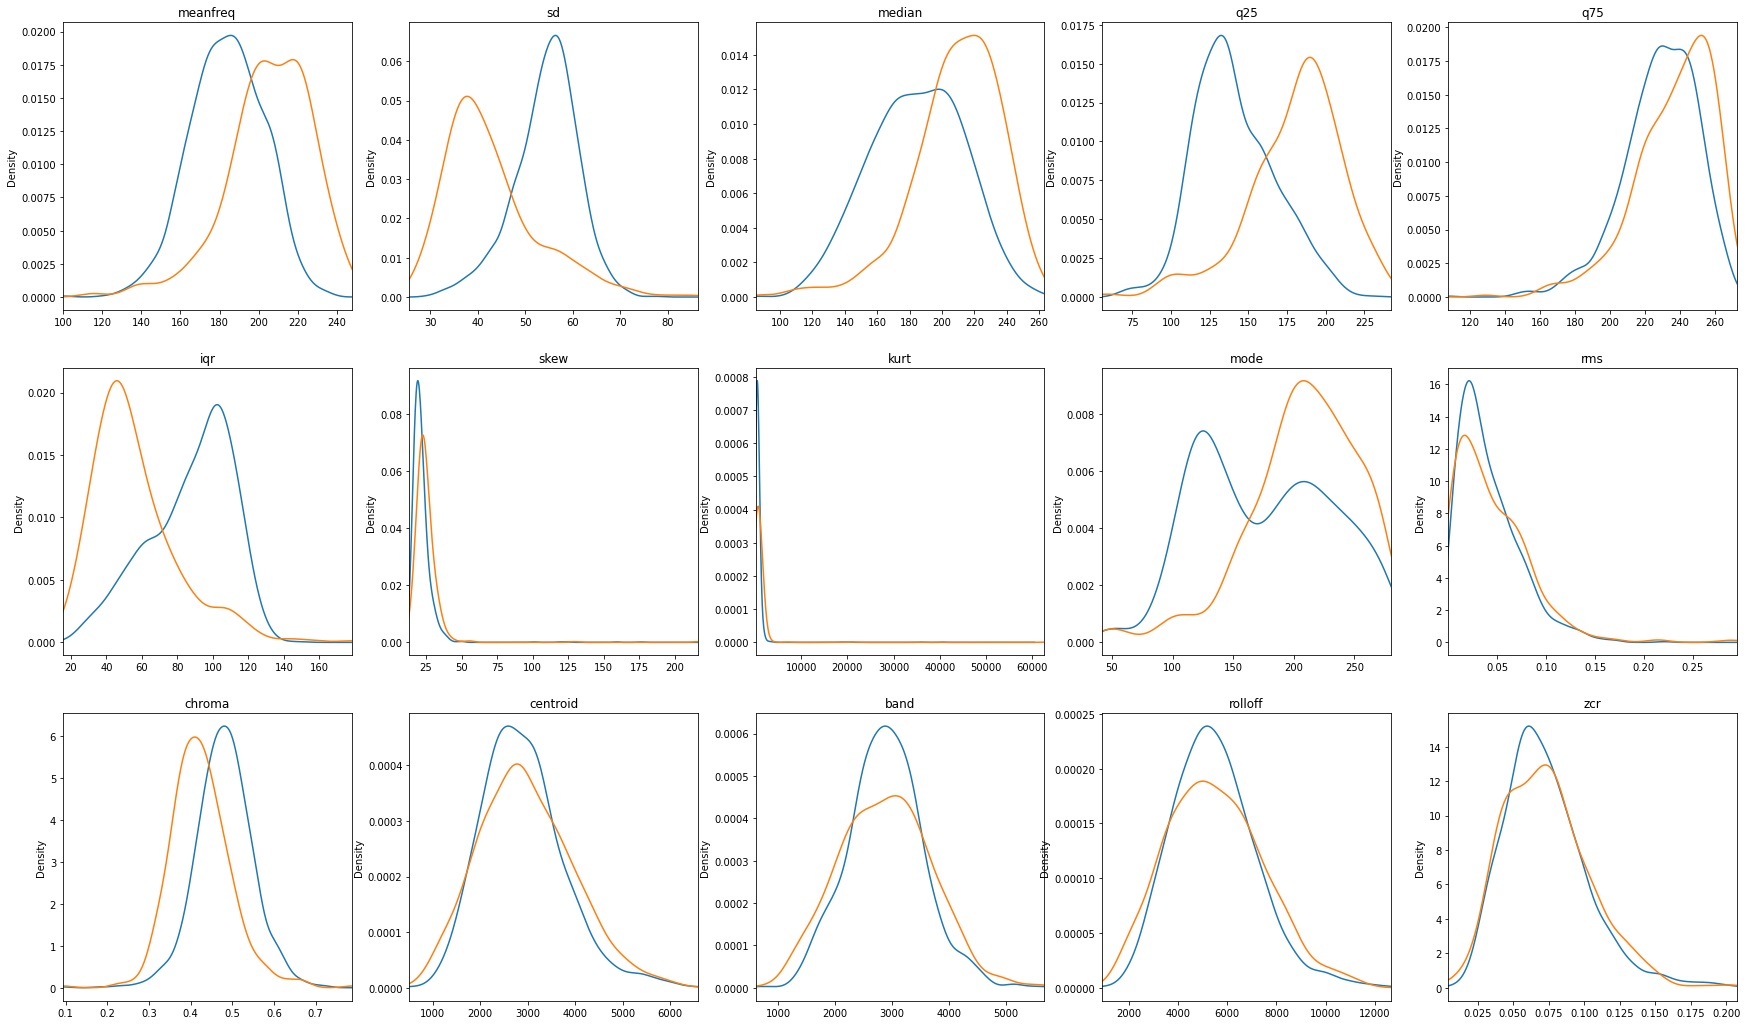

In [9]:
data_to_plot = pd.read_csv(os.path.join(dataset_folder, 'cv-valid-dev.csv'))
plt.subplots(3,5,figsize=(30, 18))
for i in range(15):
    plt.subplot(3,5,i+1)
    plt.title(columns[i])
    d = data_to_plot.loc[:, columns[i]]

    d.loc[data_to_plot['label'] == 'male'].plot(kind='density', xlim=[d.min(), d.max()])
    d.loc[data_to_plot['label'] == 'female'].plot(kind='density', xlim=[d.min(), d.max()])

<AxesSubplot:ylabel='Density'>

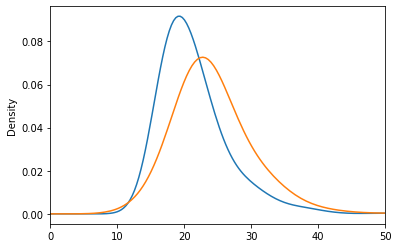

In [10]:
d = data_to_plot.loc[:, 'skew']
d.loc[data_to_plot['label'] == 'male'].plot(kind='density', xlim=[0, 50])
d.loc[data_to_plot['label'] == 'female'].plot(kind='density', xlim=[0, 50])

<AxesSubplot:ylabel='Density'>

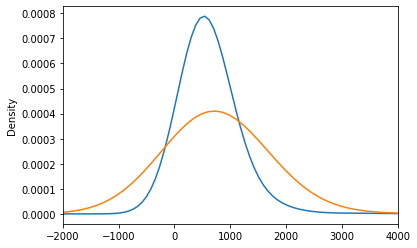

In [11]:
d = data_to_plot.loc[:, 'kurt']
d.loc[data_to_plot['label'] == 'male'].plot(kind='density', xlim=[-2000, 4000])
d.loc[data_to_plot['label'] == 'female'].plot(kind='density', xlim=[-2000, 4000])